In [1]:
from matplotlib import pyplot as plt
import cellpylib as cpl
import numpy as np
import cv2

def vote_rule(neighbor, c, t):
    """Vote rule for cellular automaton

    Args:
        neighbor (_type_): neighbor cell state
        c (_type_): current cell index
        t (_type_): time step
    """
    return 1 if np.sum(neighbor) > 4 else 0

def show_all_ca_timeseries(ca):
    fig, ax = plt.subplots(1, len(ca), figsize=(15, 5))
    for i, c in enumerate(ca):
        ax[i].imshow(c, cmap='Greys', interpolation='nearest')
        ax[i].set_title("step = {}".format(i))
        ax[i].axis('off')
    plt.show()


def generate_watermark(key, size, rule=vote_rule, steps=10, show_plots=True, blur_size=(5, 5)):
    np.random.seed(key)
    cellular_automaton = cpl.init_random2d(*size)
    init_img = np.where(cellular_automaton[0] == 0, 0, 255)
    
    cellular_automaton = cpl.evolve2d(cellular_automaton, timesteps=steps, neighbourhood='Moore',
                                    apply_rule=rule, memoize='recursive')

    if show_plots:
        show_all_ca_timeseries(cellular_automaton)
    
    gray_image = np.where(cellular_automaton[-1] == 0, 0, 255)
    ca_image = np.array(gray_image, dtype=np.uint8) 
    
    blurred_img = cv2.blur(ca_image, blur_size)
    
    if show_plots:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Random Watermark')
        plt.imshow(init_img, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('After CA')
        plt.imshow(gray_image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('After Smoothing')
        plt.imshow(blurred_img, cmap='gray')
        plt.axis('off')
        plt.show()

    return blurred_img, cellular_automaton

In [2]:
BALANCE_OFFSET = 128
BLOCK_SIZE = 8
BYTE_SIZE = 8


def visualize_dct_block_3d(dct_block):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = y = np.arange(0, 8, 1)
    X, Y = np.meshgrid(x, y)
    Z = dct_block

    ax.plot_surface(X, Y, Z)

    plt.show()

def visualize_np_array(data):
    # show data on each block
    plt.imshow(data, cmap='gray', vmin=-127, vmax=128)
    plt.colorbar()  # 显示颜色条

    # 在每个单元格上显示数字
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, data[i, j], ha='center', va='center', color='black')

    plt.show()

def set_lsb(block, bit):
    mask = 0x1F
    set_bit = bit * 0xF
    block[0][0] = np.float32(int(block[0][0]) & ~mask | set_bit)

def read_lsb(block):
    if block[0][0] > 0:
        ret = int((block[0][0] + 7) / 16) & 1
    else:
        ret = int((block[0][0] - 7) / 16) & 1
    return ret

def embed_message(image, input_bytes, set_method=set_lsb, **args):
    # Check if image is large enough to hide message
    height, width = image.shape[:2]
    if (width * height) / BLOCK_SIZE**2 < len(input_bytes):
        print("Error: Message too large to encode in image")
        return False

    # Pad image to be multiple of BLOCK_SIZE
    image = (
        cv2.resize(image, (width + (BLOCK_SIZE - width % BLOCK_SIZE), height + (BLOCK_SIZE - height % BLOCK_SIZE)))
        if height % 8 or width % 8
        else image
    )
    height, width = image.shape[:2]

    # Split image into HSV channels
    Yluma, Cr, Cb = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))
    edit_ch = np.float32(Yluma)

    # Blocks are 8x8 pixel chunks of the image
    blocks = [
        edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, height, BLOCK_SIZE)
        for i in range(0, width, BLOCK_SIZE)
    ]

    dct_blocks = [np.round(cv2.dct(block)) for block in blocks]
    # Embed message in image
    message_bits = "".join([format(char, "08b") for char in input_bytes])

    for index, block in enumerate(dct_blocks):
        if index == len(message_bits):
            break
        set_method(block, int(message_bits[index]), **args)

    # Inverse DCT
    ret_blocks = [cv2.idct(block) + BALANCE_OFFSET for block in dct_blocks]
    block_height, block_width = height // BLOCK_SIZE, width // BLOCK_SIZE
    blocks_2d = [
        ret_blocks[i * block_width : (i + 1) * block_width] for i in range(block_height)
    ]

    ret_image = np.block(blocks_2d)
    ret_image = np.uint8(ret_image)
    
    return cv2.merge((ret_image, Cr, Cb))

def extract_message(image, max_length=20, read_method=read_lsb, **args):
    height, width = image.shape[:2]
    Yluma, Cr, Cb = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))
    edit_ch = np.float32(Yluma)
    
    # Break down to blocks
    blocks = [
        edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, height, BLOCK_SIZE)
        for i in range(0, width, BLOCK_SIZE)
    ]
    
    dct_blocks = [np.round(cv2.dct(block)) for block in blocks]
    # the blocks are run through quantization table
    message = ''
    # message is extracted from LSB of DCT coefficients
    for index, block in enumerate(dct_blocks):
        if index == max_length * BYTE_SIZE:
            break

        bit = read_method(block, **args)
        message += str(bit)

    return int(message, 2).to_bytes(max_length, 'big')


def extract_watermark(img, original_img):
    height, width = img.shape[:2]
    Yluma, Cr, Cb = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb))
    edit_ch = np.float32(Yluma)
    
    # Break down to blocks
    blocks = [
        edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, height, BLOCK_SIZE)
        for i in range(0, width, BLOCK_SIZE)
    ]
    
    dct_blocks = [np.round(cv2.dct(block)) for block in blocks]
    
    original_height, original_width = original_img.shape[:2]
    original_Yluma, _, _ = cv2.split(cv2.cvtColor(original_img, cv2.COLOR_BGR2YCrCb))
    original_edit_ch = np.float32(original_Yluma)
    
    original_blocks = [
        original_edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, original_height, BLOCK_SIZE)
        for i in range(0, original_width, BLOCK_SIZE)
    ]
    
    original_dct_blocks = [np.round(cv2.dct(block)) for block in original_blocks]
    
    watermark = [1 if x[0][0] - y[0][0] > 0 else 0 for x, y in zip(dct_blocks, original_dct_blocks)]
    
    return watermark

In [3]:
def set_alpha(block, bit, alpha=1):
    if bit == 1:
        block[0][0] = np.float32(int(block[0][0]) + alpha * bit)

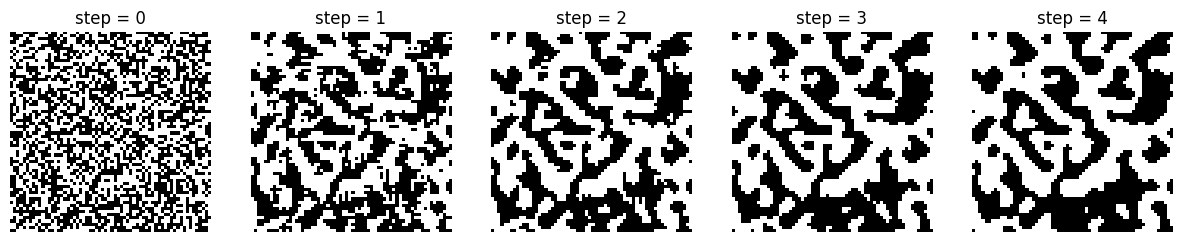

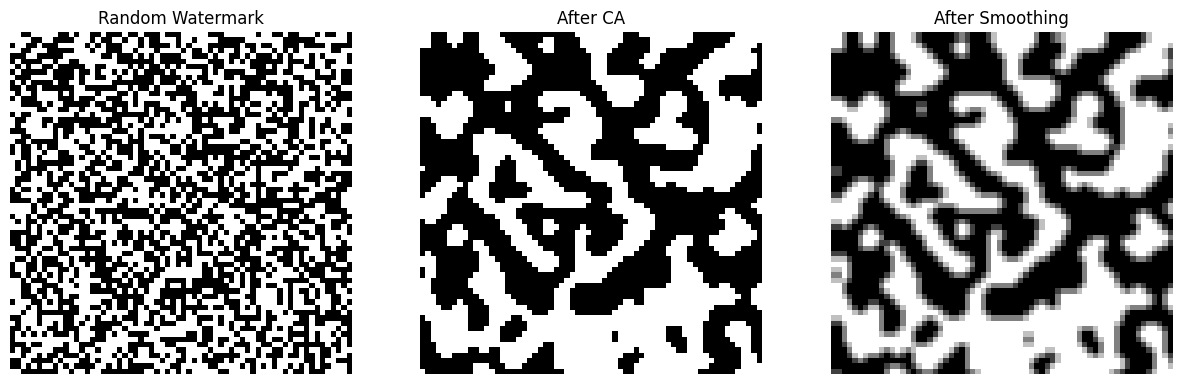

[199  30   0   7 252 127 224  31 199  31   1 131 252  31 224  63 194  31
 131 131 248  31 192 126   0  31 193 129 240  28   1 252   0  15 224   0
 224  56   3 254   0   7 240   0 224 120   7 254   0   3 248   0 224  48
  15 254   0   3 248   0 224   0  31 252   0   7 240   0 255 128  63 128
   0  15 224   0 127 192  31   0   0  15 128   0  63 192  15   0   3   0
   1 252  31 195 135   0 199 128   3 254  31 135 199 176 239 192 131 255
  15   7 195 249 255 192 129 143 128   7 195 255 255 192   0  15 128   7
 131 255  63 128   0  31 192  15   3 255  31   0   1 255 192  31 131 254
  31  12   3 255 192 255 227 254  14  63 129 255 192 255 243 255   0  63
 192 255 128 127 243 255   0  63 224 127   0   3 231 254   0  63 248  63
   0   0   7 252   0  31 124  31   0   0  15 252   0  30  62  15 248   0
  15 252 128  28  62   7 252  24  31 252   0  28  63   1 252  31 255 248
  14  60  63 128 252  31 255 240  31 120  15 192  30  12 255 224  62 120
   7 224  14   0  57 192 124 120  15 254  14   0   

In [4]:
key = 1
# watermark generation
blurred_img, cellular_automaton = generate_watermark(key, (64, 64), steps=5, show_plots=True, blur_size=(2, 2))

# from cellular_automaton[-1] to bytes
message = cellular_automaton[-1].flatten()
message = np.packbits(message)
print(message, len(message))

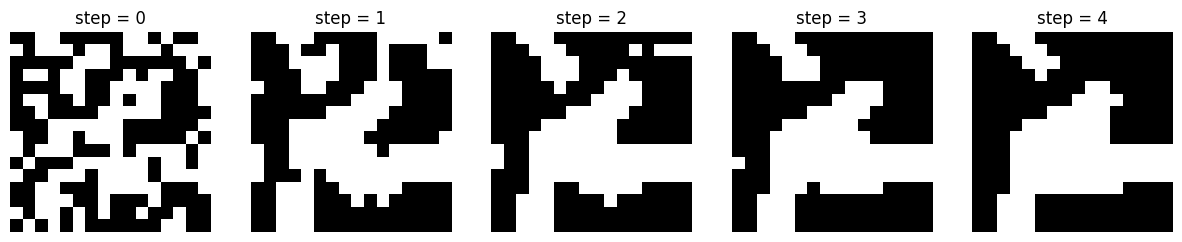

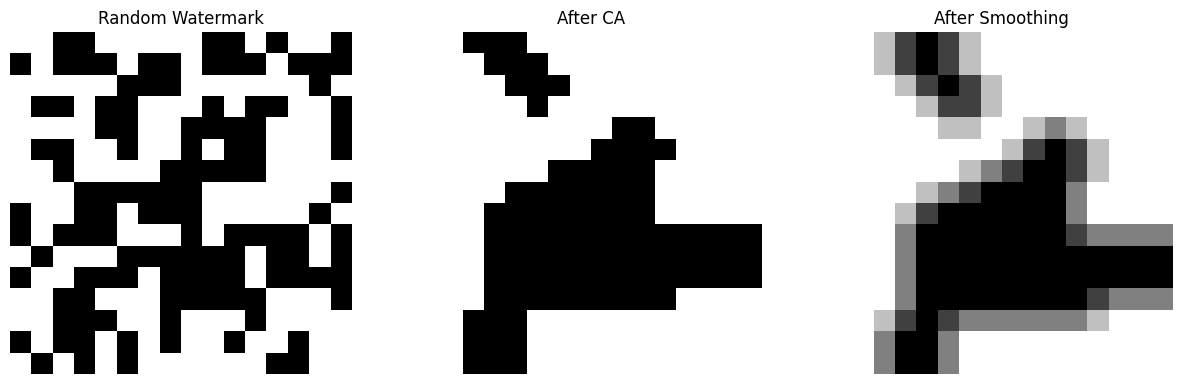

[199 255 227 255 241 255 251 255 255 159 255  15 252  31 240  31 224  31
 224   0 224   0 224   0 224  15 199 255 199 255 199 255] 32


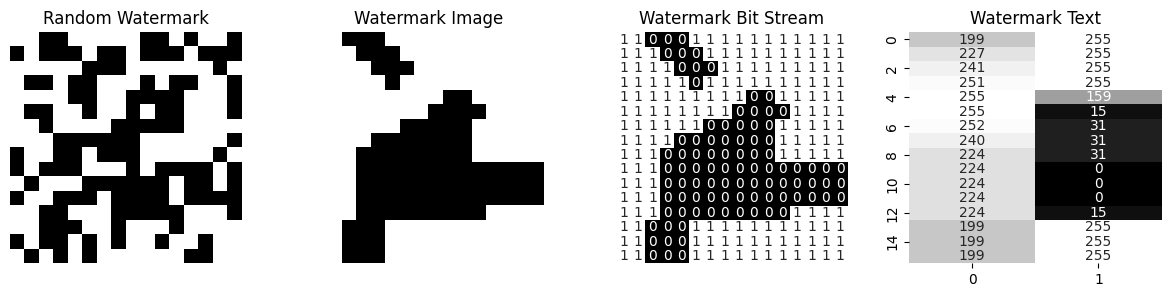

In [31]:
import seaborn as sns

key = 1
# watermark generation
blurred_img, cellular_automaton = generate_watermark(key, (16, 16), steps=5, show_plots=True, blur_size=(2, 2))

# from cellular_automaton[-1] to bytes
message = cellular_automaton[-1].flatten()
message = np.packbits(message)
print(message, len(message))

plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.title('Random Watermark')
plt.imshow(cellular_automaton[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Watermark Image')
plt.imshow(cellular_automaton[-1], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Watermark Bit Stream')
sns.heatmap(cellular_automaton[-1], cmap='gray', annot=True, cbar=False, square=True, fmt='d')
plt.grid(visible=True)
plt.axis('off')

# show text in a rectangle box
plt.subplot(1, 4, 4)
plt.title('Watermark Text')
sns.heatmap(message.reshape(16, 2), cmap='gray', annot=True, cbar=False, square=False, fmt='d')
# plt.imshow(message.reshape(16, 2), cmap='gray')
plt.show()


b'\xc7\x1e\x00\x07\xfc\x7f\xe0\x1f\xc7\x1f\x01\x83\xfc\x1f\xe0?\xc2\x1f\x83\x83\xf8\x1f\xc0~\x00\x1f\xc1\x81\xf0\x1c\x01\xfc\x00\x0f\xe0\x00\xe08\x03\xfe\x00\x07\xf0\x00\xe0x\x07\xfe\x00\x03\xf8\x00\xe00\x0f\xfe\x00\x03\xf8\x00\xe0\x00\x1f|\x00\x07\xf0\x00\xff\x80>\x80\x00\x0f\xe0\x00\x7f\xc0\x1f\x00\x00\x0f\x80\x00?\xc0\x0f\x00\x03\x00\x01\xfc\x1f\xc3\x87\x00\xc7\x80\x03\xfe\x1f\x87\xc7\xb0\xef\xc0\x83\xff\x0f\x07\xc3\xf9\xff\xc0\x81\x8f\x80\x07\xc3\xff\xff\xc0\x00\x0f\x80\x07\x83\xff?\x80\x00\x1f\xc0\x0f\x03\xff\x1f\x00\x01\xff\xc0\x1f\x83\xfe\x1f\x0c\x03\xff\xc0\xff\xe3\xfe\x0e?\x81\xff\xc0\xff\xf3\xff\x00?\xc0\xff\x80\x7f\xf3\xff\x00=\xe0\x7f\x00\x03\xe7\xfe\x00?\xf8?\x00\x00\x07\xfc\x00\x1e|\x1f\x00\x00\x0f\xfc\x00\x1e>\x0f\xf8\x00\x0f\xfc\x80\x1c>\x07\xfc\x18\x1f\xfc\x00\x1c?\x01\xfc\x1f\xff\xf8\x0e<?\x80\xfc\x1f\xff\xf0\x1fx\x0f\xc0\x1e\x0c\xff\xe0>x\x07\xe0\x0e\x009\xc0|x\x0f\xfe\x0e\x00\x00\x00\xf8<\xff\xff\x0f\x00\x00\x01\xf8\x1f\xe1\xfe\x1f\xc0\x00\x03\xf8\x0f\xc0\x00\x0f\xe

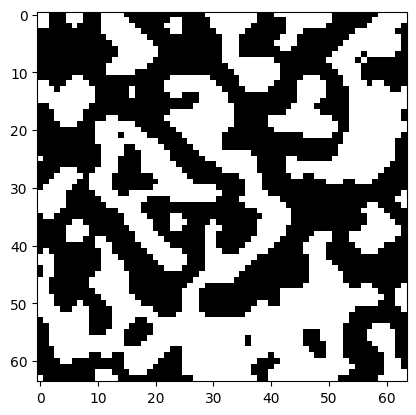

In [150]:
# no alpha control
image = cv2.imread("lenna.png", cv2.IMREAD_UNCHANGED)

embed_image = embed_message(image, message)
cv2.imwrite("lenna_embed.jpg", cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2BGR))

extract_image = cv2.imread("lenna_embed.jpg", cv2.IMREAD_UNCHANGED)
extracted_message = extract_message(extract_image, max_length=len(message))
print(bytes(extracted_message))

# extracted_message to unsigned byte data
extracted_message = np.frombuffer(extracted_message, dtype=np.uint8)

# extracted message to bytes to bits to image
extracted_message = np.unpackbits(extracted_message)
extracted_message = extracted_message.reshape(cellular_automaton[-1].shape)
plt.imshow(extracted_message, cmap='gray')

0.9697265625


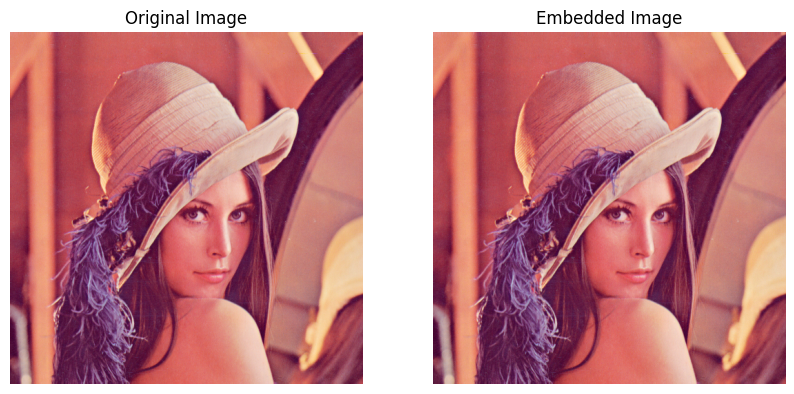

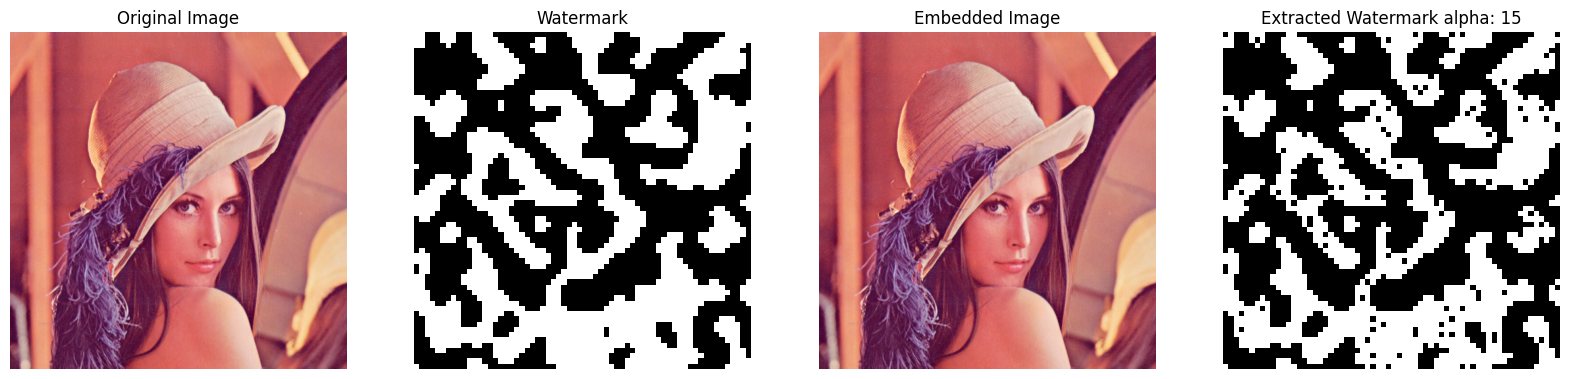

In [33]:
# 示例用法
image = cv2.imread("lenna.png", cv2.IMREAD_UNCHANGED)

key = 1
# watermark generation
blurred_img, cellular_automaton = generate_watermark(key, (64, 64), steps=5, show_plots=False, blur_size=(2, 2))
message = np.packbits(cellular_automaton[-1].flatten())

alpha = 15
embed_image = embed_message(image, message, set_method=set_alpha, alpha=alpha)
cv2.imwrite("lenna_embed.jpg", cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2BGR))

# plt.imshow(cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2RGB))
wm = extract_watermark(embed_image, cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))

# compare cellular_automaton[-1] and extracted watermark by difference rate
accuracy = 1 - np.sum(np.abs(cellular_automaton[-1].flatten() - wm)) / (64 * 64)
print(accuracy)

# compare image and embedded image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Embedded Image')
plt.imshow(cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2RGB))
plt.axis('off')

plt.show()



# compare image and embedded image
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Watermark')
plt.imshow(cellular_automaton[-1], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Embedded Image')
plt.imshow(cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2RGB))
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f'Extracted Watermark alpha: {alpha}')
plt.imshow(np.array(wm).reshape(cellular_automaton[-1].shape), cmap='gray')
plt.axis('off')

plt.show()


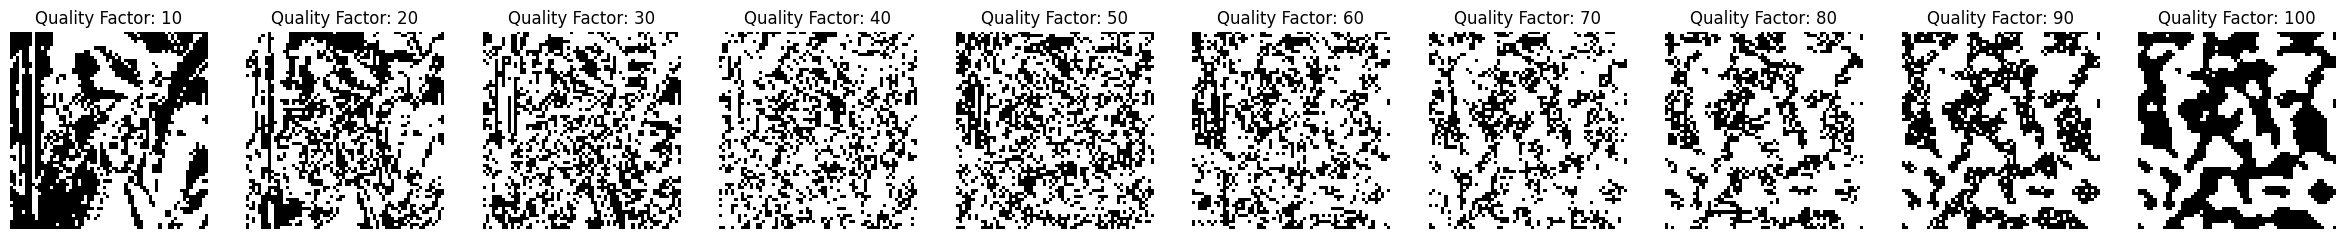

In [44]:
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

key = 0x9
# 生成实验图像
image = cv2.imread('lenna.png', cv2.IMREAD_UNCHANGED)
h, w = image.shape[:2]
alpha_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
quality_factors = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {alpha: [] for alpha in alpha_values}

# watermark generation
blurred_img, cellular_automaton = generate_watermark(key, (64, 64), steps=5, show_plots=False, blur_size=(2, 2))
message = np.packbits(cellular_automaton[-1].flatten())


# 信息嵌入和提取实验
for alpha in alpha_values:
    embedded_image = np.copy(image)

    img = embed_message(image, message, set_method=set_alpha, alpha=alpha)
    wm = extract_watermark(embed_image, cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))

    # compare cellular_automaton[-1] and extracted watermark by difference rate
    accuracy = 1 - np.sum(np.abs(cellular_automaton[-1].flatten() - wm)) / (64 * 64)
    
    wms = []
    for qf in quality_factors:
        encoded_image = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), qf])[1]
        decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_UNCHANGED)
        
        wm = extract_watermark(decoded_image, cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))
        wms.append(np.array(wm).reshape(cellular_automaton[-1].shape))
        
        accuracy = 1 - np.sum(np.abs(cellular_automaton[-1].flatten() - wm)) / (64 * 64)
        results[alpha].append((qf, accuracy))
    
    if alpha == alpha_values[-1]:
        # show compare image of all watermarks extracted
        plt.figure(figsize=(30, 5))
        for i, wm in enumerate(wms):
            plt.subplot(1, 10, i + 1)
            plt.title(f'Quality Factor: {quality_factors[i]}')
            plt.imshow(wm, cmap='gray')
            plt.axis('off')
        
        plt.show()

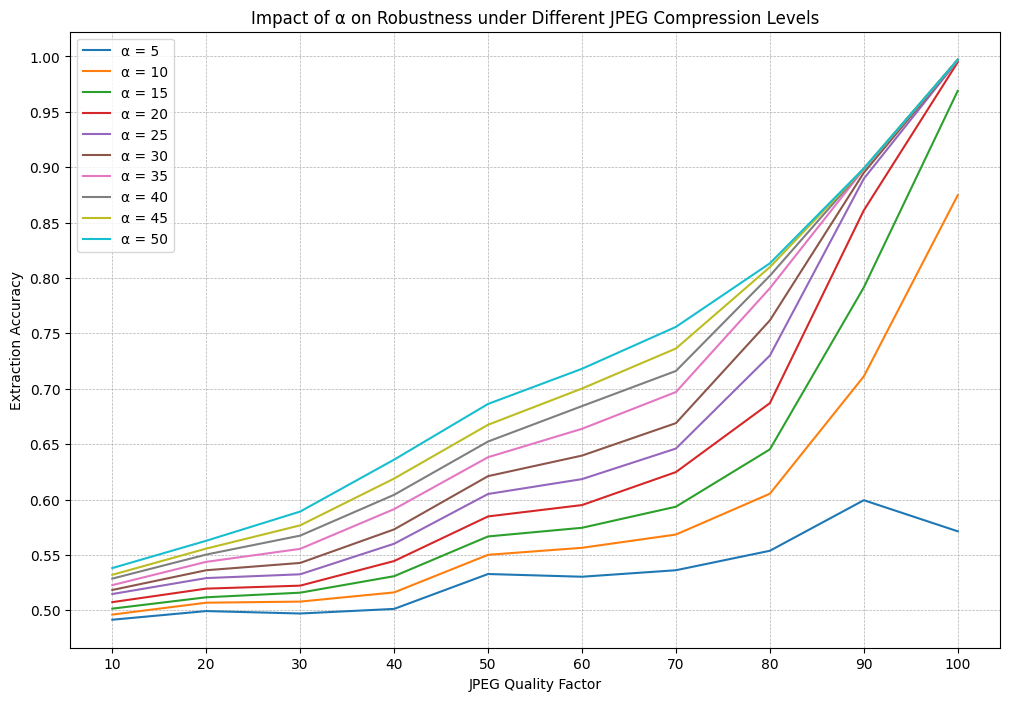

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 8))
for alpha in alpha_values:
    qfs, accuracies = zip(*results[alpha])
    ax.plot(qfs, accuracies, label=f'α = {alpha}')
    
ax.set_xlabel('JPEG Quality Factor')
ax.set_ylabel('Extraction Accuracy')
ax.set_title('Impact of α on Robustness under Different JPEG Compression Levels')
ax.legend()

ax.set_xticks(range(10, 110, 10))
ax.set_yticks(np.linspace(0.5, 1, 11))

# ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 在每个主要刻度之间添加1个次要刻度
# ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 在每个主要刻度之间添加1个次要刻度

ax.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

In [154]:
image = cv2.imread("lenna.png", cv2.IMREAD_UNCHANGED)

key = 9
# watermark generation
blurred_img, cellular_automaton = generate_watermark(key, (64, 64), steps=5, show_plots=False, blur_size=(2, 2))
message = np.packbits(cellular_automaton[-1].flatten())

alpha = 5
embed_image = embed_message(image, message, set_method=set_alpha, alpha=alpha)
cv2.imwrite("lenna_embed.jpg", cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2BGR))

wm = extract_watermark(embed_image, cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))

from scipy.stats import pearsonr

val, _ = pearsonr(cellular_automaton[-1].flatten(), wm)
print(val)

seeds = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
results = {}

for seed in seeds:
    key = seed
    _, cellular_automaton = generate_watermark(key, (64, 64), steps=5, show_plots=False, blur_size=(2, 2))
    val, _ = pearsonr(cellular_automaton[-1].flatten(), wm)
    results[key] = val




0.20073537492099197


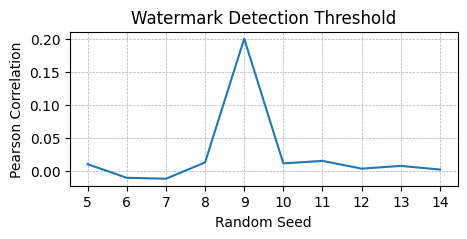

In [155]:
plt.figure(figsize=(5, 2))
plt.plot(results.keys(), results.values())
plt.xticks(seeds)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Random Seed')
plt.ylabel('Pearson Correlation')
plt.title('Watermark Detection Threshold')
plt.show()